# Building the Data Analyst Agent with LangGraph (Enhanced)

This notebook builds a robust Data Analyst Agent with:
- **Pydantic models** for structured LLM outputs
- **Error handling** with retry logic for SQL queries
- **Opik observability** for full tracing

## Enhancements

1. **Query Parser**: Uses Pydantic `QueryClassification` model for type-safe outputs
2. **SQL Executor**: Includes retry loop with error feedback to LLM
3. **Better validation**: Schema validation before execution
4. **Confidence scores**: Track classification confidence

## Step 1: Install Dependencies

In [1]:
# Uncomment to install dependencies (if needed)
# !pip install langchain langgraph langchain-openai duckdb plotly scikit-learn opik pandas openpyxl python-dotenv tiktoken pydantic

In [2]:
# Import all required libraries
import os
import pandas as pd
import duckdb
import plotly.express as px
from datetime import datetime
from typing import TypedDict, Annotated, List, Optional, Literal
import warnings
warnings.filterwarnings('ignore')

# Pydantic for structured outputs
from pydantic import BaseModel, Field

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

# Opik for observability
from opik import track
from opik.integrations.langchain import OpikTracer

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

print("✅ All imports successful!")

✅ All imports successful!


## Step 2: Load Data with DuckDB

In [3]:
class SupplyChainDBManager:
    """Manages supply chain data in DuckDB"""
    
    def __init__(self, data_dir: str = '../data'):
        self.data_dir = data_dir
        self.conn = duckdb.connect(':memory:')
        self.tables = {}
        print("📦 Initializing DuckDB database...")
        
    def load_csv_with_encoding(self, file_path: str) -> pd.DataFrame:
        """Load CSV with automatic encoding detection"""
        encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        for encoding in encodings:
            try:
                df = pd.read_csv(file_path, encoding=encoding)
                print(f"  ✓ Loaded {os.path.basename(file_path)} with {encoding}")
                return df
            except UnicodeDecodeError:
                continue
        raise ValueError(f"Could not read {file_path}")
    
    def load_all_datasets(self):
        """Load all datasets into DuckDB"""
        print("\n📊 Loading datasets...\n")
        
        # Load all 4 datasets
        dataco_df = self.load_csv_with_encoding(f"{self.data_dir}/DataCoSupplyChainDataset.csv")
        dataco_df.columns = [col.strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for col in dataco_df.columns]
        self.conn.register('dataco_supply_chain', dataco_df)
        self.tables['dataco_supply_chain'] = dataco_df
        
        logistics_df = self.load_csv_with_encoding(f"{self.data_dir}/dynamic_supply_chain_logistics_dataset.csv")
        logistics_df.columns = [col.strip().lower().replace(' ', '_') for col in logistics_df.columns]
        self.conn.register('logistics', logistics_df)
        self.tables['logistics'] = logistics_df
        
        supply_df = self.load_csv_with_encoding(f"{self.data_dir}/supply_chain_data.csv")
        supply_df.columns = [col.strip().lower().replace(' ', '_') for col in supply_df.columns]
        self.conn.register('supply_chain', supply_df)
        self.tables['supply_chain'] = supply_df
        
        retail_df = pd.read_excel(f"{self.data_dir}/Retail-Supply-Chain-Sales-Dataset.xlsx")
        retail_df.columns = [col.strip().lower().replace(' ', '_') for col in retail_df.columns]
        self.conn.register('retail_sales', retail_df)
        self.tables['retail_sales'] = retail_df
        
        print(f"\n✅ Loaded {len(self.tables)} tables into DuckDB")
    
    def get_schema(self) -> str:
        """Get detailed schema for LLM context"""
        schema_parts = []
        for table_name, df in self.tables.items():
            schema_parts.append(f"\nTable: {table_name}")
            schema_parts.append(f"Columns: {', '.join(df.columns.tolist())}")
            schema_parts.append(f"Rows: {len(df):,}")
            # Add sample values for first few columns
            schema_parts.append("Sample data:")
            for col in df.columns[:5]:
                sample_vals = df[col].dropna().head(3).tolist()
                schema_parts.append(f"  {col}: {sample_vals}")
        return "\n".join(schema_parts)
    
    def execute_query(self, query: str) -> tuple[pd.DataFrame, Optional[str]]:
        """Execute SQL query and return results + error message if any"""
        try:
            # Add LIMIT if not present
            if 'LIMIT' not in query.upper():
                query = query.rstrip(';') + ' LIMIT 1000'
            result = self.conn.execute(query).df()
            return result, None
        except Exception as e:
            error_msg = str(e)
            return pd.DataFrame(), error_msg

# Initialize database
db = SupplyChainDBManager()
db.load_all_datasets()

📦 Initializing DuckDB database...

📊 Loading datasets...

  ✓ Loaded DataCoSupplyChainDataset.csv with latin-1
  ✓ Loaded dynamic_supply_chain_logistics_dataset.csv with utf-8
  ✓ Loaded supply_chain_data.csv with utf-8

✅ Loaded 4 tables into DuckDB


## Step 3: Define Pydantic Models for Structured Outputs

These models ensure type-safe, validated responses from the LLM.

In [4]:
from typing import Dict, Any

class QueryEntities(BaseModel):
    """Extracted entities from query"""
    metrics: List[str] = Field(default_factory=list, description="Metrics to measure (e.g., ['sales', 'profit', 'count'])")
    dimensions: List[str] = Field(default_factory=list, description="Dimensions to group by (e.g., ['region', 'category'])")
    filters: List[str] = Field(default_factory=list, description="Filter conditions (e.g., ['date > 2024-01-01', 'region = East'])")
    time_period: Optional[str] = Field(default=None, description="Time period if specified (e.g., 'last 30 days', 'Q1 2024')")
    other_details: Optional[str] = Field(default=None, description="Any other relevant details")

class QueryClassification(BaseModel):
    """Structured output for query parsing"""
    query_type: Literal['sql', 'anomaly', 'trend', 'visualization'] = Field(
        description="Type of query: sql for database queries, anomaly for outlier detection, trend for time-series, visualization for charts"
    )
    intent: str = Field(
        description="Clear, concise description of what the user wants to accomplish"
    )
    entities: QueryEntities = Field(
        default_factory=QueryEntities,
        description="Extracted entities like metrics, dimensions, filters, and time periods"
    )
    confidence: float = Field(
        ge=0.0, le=1.0,
        description="Confidence score for the classification (0-1)"
    )
    reasoning: str = Field(
        description="Brief explanation of why this classification was chosen"
    )

class SQLQueryGeneration(BaseModel):
    """Structured output for SQL generation"""
    sql_query: str = Field(
        description="The generated SQL query, properly formatted and valid for DuckDB"
    )
    explanation: str = Field(
        description="Brief explanation of what the query does and why it was structured this way"
    )
    tables_used: List[str] = Field(
        description="List of table names used in the query"
    )
    expected_columns: List[str] = Field(
        description="Expected column names in the result set"
    )

print("✅ Pydantic models defined")

✅ Pydantic models defined


## Step 4: Define Agent State

In [5]:
class DataAnalystState(TypedDict):
    """State for Data Analyst Agent"""
    user_query: str
    messages: Annotated[List[BaseMessage], "Conversation messages"]
    
    # Query Analysis (now structured)
    query_classification: Optional[QueryClassification]
    
    # SQL Execution
    sql_generation: Optional[SQLQueryGeneration]
    query_results: Optional[pd.DataFrame]
    sql_attempts: int  # Track retry attempts
    last_sql_error: Optional[str]  # Last error message
    
    # Analysis
    insights: List[str]
    anomalies: List[dict]
    charts: List[dict]
    
    # Output
    final_response: Optional[str]
    error: Optional[str]

print("✅ State schema defined")

✅ State schema defined


## Step 5: Initialize LLM with Structured Outputs

In [6]:
# Base LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    callbacks=[OpikTracer()]
)

# LLM with structured output for query classification
llm_classifier = llm.with_structured_output(QueryClassification)

# LLM with structured output for SQL generation
llm_sql = llm.with_structured_output(SQLQueryGeneration)

print("✅ LLMs initialized with structured outputs and Opik tracing")

✅ LLMs initialized with structured outputs and Opik tracing


## Step 6: Build Enhanced Agent Nodes

### Node 1: Query Parser (Enhanced with Pydantic)

In [7]:
def parse_query_node(state: DataAnalystState) -> DataAnalystState:
    """Parse user query with structured output"""
    print("\n🔍 Node: Query Parser (Structured)")
    
    user_query = state['user_query']
    
    prompt = f"""You are an expert query classifier for a supply chain analytics system.

User Query: "{user_query}"

Available Data:
- dataco_supply_chain: 180K orders with shipping, delivery, customer, product data
- logistics: 32K records with GPS, inventory, risk, IoT sensor data
- retail_sales: 10K retail orders with profit, returns, regional data
- supply_chain: 100 records with manufacturing, procurement data

Classify this query and extract relevant entities.

Query Types:
- 'sql': Needs database query (e.g., "What's average sales by region?")
- 'anomaly': Needs outlier detection (e.g., "Find unusual delivery times")
- 'trend': Needs time-series analysis (e.g., "Show sales trends over time")
- 'visualization': Primary goal is creating a specific chart (e.g., "Plot profit by category")

Extract entities into structured format:
- metrics: List of metrics to measure (e.g., sales, profit, count, average_delay)
- dimensions: List of dimensions to group by (e.g., region, category, city)
- filters: List of filter conditions (e.g., date ranges, status values)
- time_period: Any time period mentioned
- other_details: Other relevant information

Provide:
1. query_type: The classification
2. intent: What the user wants to accomplish
3. entities: Structured extraction with metrics, dimensions, filters, etc.
4. confidence: How confident you are (0-1)
5. reasoning: Why you chose this classification
"""
    
    # Get structured output
    classification: QueryClassification = llm_classifier.invoke(prompt)
    
    print(f"  Query Type: {classification.query_type}")
    print(f"  Intent: {classification.intent}")
    print(f"  Confidence: {classification.confidence:.2f}")
    print(f"  Entities:")
    print(f"    - Metrics: {classification.entities.metrics}")
    print(f"    - Dimensions: {classification.entities.dimensions}")
    print(f"    - Filters: {classification.entities.filters}")
    if classification.entities.time_period:
        print(f"    - Time Period: {classification.entities.time_period}")
    print(f"  Reasoning: {classification.reasoning}")
    
    state['query_classification'] = classification
    state['messages'].append(HumanMessage(content=user_query))
    
    return state

print("✅ Enhanced Query Parser created")

✅ Enhanced Query Parser created


### Node 2: SQL Executor (Enhanced with Retry Logic)

In [8]:
def execute_sql_node(state: DataAnalystState) -> DataAnalystState:
    """Generate and execute SQL with error handling and retry"""
    print("\n💾 Node: SQL Executor (with Retry Logic)")
    
    classification = state['query_classification']
    max_attempts = 3
    attempt = state.get('sql_attempts', 0)
    
    if attempt >= max_attempts:
        print(f"  ❌ Max retry attempts ({max_attempts}) reached")
        state['error'] = f"Failed to generate valid SQL after {max_attempts} attempts"
        return state
    
    # Increment attempt counter
    state['sql_attempts'] = attempt + 1
    
    # Get schema
    schema = db.get_schema()
    
    # Build prompt with error feedback if retrying
    base_prompt = f"""You are a SQL expert for a supply chain DuckDB database.

Database Schema:
{schema}

User Intent: {classification.intent}
Extracted Entities: {classification.entities}

Generate a valid DuckDB SQL query following these rules:
1. Use ONLY tables from the schema above
2. Use proper column names (check schema carefully)
3. Use aliases for better readability
4. For aggregations, always include GROUP BY
5. Handle NULL values appropriately (use COALESCE or WHERE IS NOT NULL)
6. Do NOT add LIMIT (will be added automatically)
7. For date filtering, convert string dates using strptime() or TRY_CAST
8. Use LOWER() for case-insensitive string comparisons
"""
    
    # Add error feedback if retrying
    if attempt > 0 and state.get('last_sql_error'):
        base_prompt += f"""

⚠️  PREVIOUS ATTEMPT FAILED:
Error: {state['last_sql_error']}
Previous Query: {state['sql_generation'].sql_query if state.get('sql_generation') else 'N/A'}

Fix the error and generate a corrected query. Common fixes:
- Check column names match schema exactly (case-sensitive)
- Ensure all columns in SELECT are in GROUP BY (if using aggregation)
- Use proper DuckDB syntax for dates and strings
- Verify table names are spelled correctly
"""
    
    print(f"  Attempt {state['sql_attempts']}/{max_attempts}")
    
    # Generate SQL with structured output
    sql_gen: SQLQueryGeneration = llm_sql.invoke(base_prompt)
    
    print(f"\n  Generated SQL:\n  {sql_gen.sql_query}")
    print(f"  Explanation: {sql_gen.explanation}")
    print(f"  Tables Used: {sql_gen.tables_used}")
    print(f"  Expected Columns: {sql_gen.expected_columns}")
    
    # Execute query
    results, error = db.execute_query(sql_gen.sql_query)
    
    if error:
        # Query failed - store error and retry
        print(f"  ❌ SQL Error: {error}")
        state['last_sql_error'] = error
        state['sql_generation'] = sql_gen
        
        # Recursive call for retry
        return execute_sql_node(state)
    
    # Success!
    print(f"  ✅ Query successful! Returned {len(results)} rows")
    state['sql_generation'] = sql_gen
    state['query_results'] = results
    state['last_sql_error'] = None
    
    return state

print("✅ Enhanced SQL Executor with retry logic created")

✅ Enhanced SQL Executor with retry logic created


### Node 3: Anomaly Detector

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

def detect_anomalies_node(state: DataAnalystState) -> DataAnalystState:
    """Detect anomalies in delivery and logistics data"""
    print("Node: Anomaly Detector")
    
    query = """
    SELECT 
        order_id,
        customer_city,
        days_for_shipping_real,
        days_for_shipment_scheduled,
        (days_for_shipping_real - days_for_shipment_scheduled) as delay,
        delivery_status,
        late_delivery_risk
    FROM dataco_supply_chain
    WHERE days_for_shipping_real IS NOT NULL
    """
    
    results, error = db.execute_query(query)
    
    if error:
        print(f"Error: {error}")
        state['error'] = error
        return state
    
    anomalies = []
    
    if not results.empty and 'delay' in results.columns:
        # Statistical anomaly detection
        mean_delay = results['delay'].mean()
        std_delay = results['delay'].std()
        threshold = mean_delay + (2 * std_delay)
        
        severe_delays = results[results['delay'] > threshold]
        
        if len(severe_delays) > 0:
            anomalies.append({
                'type': 'severe_late_delivery',
                'count': len(severe_delays),
                'avg_delay': float(severe_delays['delay'].mean()),
                'max_delay': float(severe_delays['delay'].max()),
                'threshold': float(threshold),
                'affected_cities': severe_delays['customer_city'].value_counts().head(5).to_dict()
            })
            
            print(f"  ⚠️  Found {len(severe_delays)} severe delays (>{threshold:.1f} days)")
            print(f"     Average delay: {severe_delays['delay'].mean():.1f} days")
            print(f"     Max delay: {severe_delays['delay'].max():.1f} days")
    
    state['anomalies'] = anomalies
    state['query_results'] = results
    
    return state

print("✅ Anomaly Detector created")

✅ Anomaly Detector created


### Node 4: Visualizer

In [10]:
def visualize_node(state: DataAnalystState) -> DataAnalystState:
    """Generate visualizations from query results"""
    print("\n📊 Node: Visualizer")
    
    results = state.get('query_results')
    charts = []
    
    if results is not None and not results.empty and len(results.columns) >= 2:
        first_col = results.columns[0]
        second_col = results.columns[1]
        
        # Auto-detect chart type
        if pd.api.types.is_numeric_dtype(results[second_col]):
            # Create bar chart
            fig = px.bar(
                results.head(15),
                x=first_col,
                y=second_col,
                title=f"{second_col.replace('_', ' ').title()} by {first_col.replace('_', ' ').title()}",
                labels={first_col: first_col.replace('_', ' ').title(), 
                        second_col: second_col.replace('_', ' ').title()}
            )
            fig.update_layout(xaxis_tickangle=-45)
            
            charts.append({
                'type': 'bar',
                'title': f"{second_col} by {first_col}",
                'figure': fig
            })
            print(f"  ✅ Created bar chart: {second_col} by {first_col}")
    
    state['charts'] = charts
    return state

print("✅ Visualizer created")

✅ Visualizer created


### Node 5: Response Generator

In [11]:
def generate_response_node(state: DataAnalystState) -> DataAnalystState:
    """Generate comprehensive insights"""
    print("\n📝 Node: Response Generator")
    
    classification = state.get('query_classification')
    sql_gen = state.get('sql_generation')
    results = state.get('query_results')
    anomalies = state.get('anomalies', [])
    charts = state.get('charts', [])
    
    # Build context
    context_parts = []
    
    if classification:
        context_parts.append(f"Query Type: {classification.query_type}")
        context_parts.append(f"User Intent: {classification.intent}")
    
    if sql_gen:
        context_parts.append(f"\nSQL Query:\n{sql_gen.sql_query}")
        context_parts.append(f"Query Explanation: {sql_gen.explanation}")
    
    if results is not None and not results.empty:
        context_parts.append(f"\nResults: {len(results)} rows, {len(results.columns)} columns")
        context_parts.append(f"Columns: {', '.join(results.columns.tolist())}")
        context_parts.append(f"\nData Preview:\n{results.head(10).to_string()}")
        
        # Add statistics for numeric columns
        numeric_cols = results.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            context_parts.append(f"\nStatistics:")
            for col in numeric_cols:
                context_parts.append(f"  {col}: mean={results[col].mean():.2f}, min={results[col].min():.2f}, max={results[col].max():.2f}")
    
    if anomalies:
        context_parts.append(f"\n⚠️  Anomalies Detected:")
        for anom in anomalies:
            context_parts.append(f"  {anom}")
    
    if charts:
        context_parts.append(f"\n📊 {len(charts)} visualization(s) created")
    
    context = "\n".join(context_parts)
    
    # Generate insights
    prompt = f"""You are a senior supply chain data analyst.

User Query: {state['user_query']}

Analysis Context:
{context}

Provide a professional analysis report with:

## Key Findings
- 2-3 specific, data-driven bullet points
- Include actual numbers and percentages

## Analysis
- Interpret the data
- Highlight notable patterns or trends
- Explain significance of findings

## Recommendations
- 1-2 actionable recommendations based on the data

Use markdown formatting. Be concise but thorough.
"""
    
    response = llm.invoke(prompt)
    final_response = response.content
    
    print("  ✅ Generated comprehensive insights")
    
    state['final_response'] = final_response
    state['messages'].append(AIMessage(content=final_response))
    
    return state

print("✅ Response Generator created")

✅ Response Generator created


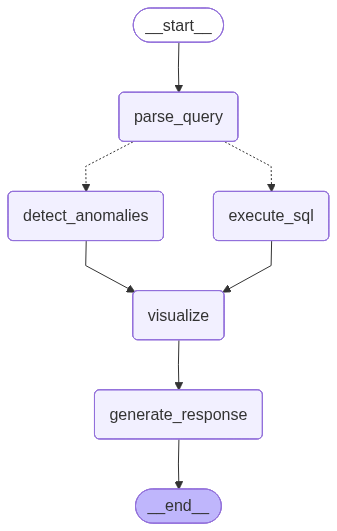

In [17]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

## Step 7: Build LangGraph Workflow

In [12]:
def route_query(state: DataAnalystState) -> str:
    """Route based on query classification"""
    classification = state.get('query_classification')
    if not classification:
        return 'execute_sql'
    
    query_type = classification.query_type
    
    if query_type == 'anomaly':
        return 'detect_anomalies'
    else:
        return 'execute_sql'

# Create graph
workflow = StateGraph(DataAnalystState)

# Add nodes
workflow.add_node("parse_query", parse_query_node)
workflow.add_node("execute_sql", execute_sql_node)
workflow.add_node("detect_anomalies", detect_anomalies_node)
workflow.add_node("visualize", visualize_node)
workflow.add_node("generate_response", generate_response_node)

# Set entry point
workflow.set_entry_point("parse_query")

# Add routing
workflow.add_conditional_edges(
    "parse_query",
    route_query,
    {
        "execute_sql": "execute_sql",
        "detect_anomalies": "detect_anomalies"
    }
)

# Connect to visualizer
workflow.add_edge("execute_sql", "visualize")
workflow.add_edge("detect_anomalies", "visualize")
workflow.add_edge("visualize", "generate_response")
workflow.add_edge("generate_response", END)

# Compile
agent = workflow.compile()

print("✅ Enhanced LangGraph workflow compiled!")

✅ Enhanced LangGraph workflow compiled!


## Step 8: Create Agent Interface

In [13]:
class DataAnalystAgent:
    """Enhanced Data Analyst Agent"""
    
    def __init__(self, graph, db_manager):
        self.graph = graph
        self.db = db_manager
    
    @track(name="data_analyst_query", project_name="omnisupply-data-analyst")
    def analyze(self, query: str) -> dict:
        """Analyze a user query with full tracing"""
        print("="*80)
        print(f"🤖 Enhanced Data Analyst Agent")
        print(f"📝 Query: {query}")
        print("="*80)
        
        initial_state = {
            "user_query": query,
            "messages": [],
            "query_classification": None,
            "sql_generation": None,
            "query_results": None,
            "sql_attempts": 0,
            "last_sql_error": None,
            "insights": [],
            "anomalies": [],
            "charts": [],
            "final_response": None,
            "error": None
        }
        
        result = self.graph.invoke(
            initial_state,
            config={"callbacks": [OpikTracer()]}
        )
        
        return result

# Initialize agent
data_analyst = DataAnalystAgent(agent, db)
print("\n✅ Enhanced Data Analyst Agent ready!")


✅ Enhanced Data Analyst Agent ready!


## Step 9: Test the Enhanced Agent

In [14]:
# Test 1: Complex SQL query
result = data_analyst.analyze("What are the top 10 cities with the most orders, and what's their average delivery delay?")

print("\n" + "="*80)
print("📊 RESULTS")
print("="*80)

# Show classification
if result.get('query_classification'):
    c = result['query_classification']
    print(f"\n🔍 Classification:")
    print(f"  Type: {c.query_type}")
    print(f"  Confidence: {c.confidence:.2%}")
    print(f"  Entities: {c.entities}")

# Show SQL
if result.get('sql_generation'):
    sg = result['sql_generation']
    print(f"\n💾 SQL Generation:")
    print(f"  Query: {sg.sql_query}")
    print(f"  Attempts: {result.get('sql_attempts', 1)}")

# Show insights
print(f"\n📝 Analysis:\n")
print(result['final_response'])

# Show data
if result.get('query_results') is not None:
    print("\n📋 Data:")
    display(result['query_results'])

# Show charts
if result.get('charts'):
    for chart in result['charts']:
        chart['figure'].show()

OPIK: Started logging traces to the "omnisupply-data-analyst" project at https://www.comet.com/opik/api/v1/session/redirect/projects/?trace_id=019ae0b1-45ce-7e16-a9a8-dc61fd85c624&path=aHR0cHM6Ly93d3cuY29tZXQuY29tL29waWsvYXBpLw==.


🤖 Enhanced Data Analyst Agent
📝 Query: What are the top 10 cities with the most orders, and what's their average delivery delay?

🔍 Node: Query Parser (Structured)
  Query Type: sql
  Intent: Retrieve the top 10 cities with the most orders and their average delivery delay.
  Confidence: 0.95
  Entities:
    - Metrics: ['count', 'average_delivery_delay']
    - Dimensions: ['city']
    - Filters: []
  Reasoning: The query asks for specific metrics (top cities by order count and average delivery delay), which indicates a need for a database query to aggregate and retrieve this information.

💾 Node: SQL Executor (with Retry Logic)
  Attempt 1/3

  Generated SQL:
  SELECT 
    LOWER(customer_city) AS city, 
    COUNT(order_id) AS order_count, 
    AVG(DATEDIFF(shipping_date_dateorders, order_date_dateorders)) AS average_delivery_delay 
FROM 
    dataco_supply_chain 
WHERE 
    shipping_date_dateorders IS NOT NULL AND order_date_dateorders IS NOT NULL 
GROUP BY 
    LOWER(customer_city) 
ORD

OPIK: Filtering large LangGraph output (8230 chars) for thread display


  ✅ Generated comprehensive insights

📊 RESULTS

🔍 Classification:
  Type: sql
  Confidence: 95.00%
  Entities: metrics=['count', 'average_delivery_delay'] dimensions=['city'] filters=[] time_period=None other_details=None

💾 SQL Generation:
  Query: SELECT 
    LOWER(customer_city) AS city, 
    COUNT(order_id) AS order_count, 
    AVG(DATEDIFF('day', TRY_CAST(shipping_date_dateorders AS TIMESTAMP), TRY_CAST(order_date_dateorders AS TIMESTAMP))) AS average_delivery_delay 
FROM 
    dataco_supply_chain 
WHERE 
    shipping_date_dateorders IS NOT NULL AND order_date_dateorders IS NOT NULL 
GROUP BY 
    LOWER(customer_city) 
ORDER BY 
    order_count DESC;
  Attempts: 2

📝 Analysis:

# Supply Chain Analysis Report

## Key Findings
- **Order Volume**: The city of **Caguas** leads significantly with **66,770 orders**, accounting for approximately **88.5%** of the total orders in the dataset, indicating a potential hub for high demand.
- **Average Delivery Delay**: The average delivery del

,city,order_count,average_delivery_delay
0,caguas,66770,NaN
1,chicago,3885,NaN
2,los angeles,3417,NaN
3,brooklyn,3412,NaN
4,new york,1816,NaN
...,...,...,...
558,bartlett,25,NaN
559,ponce,22,NaN
560,malden,22,NaN
561,freehold,13,NaN


In [15]:
# Test 2: Anomaly detection
result = data_analyst.analyze("Find deliveries with unusual delays")

print("\n" + "="*80)
print("📊 ANOMALY DETECTION RESULTS")
print("="*80)
print(result['final_response'])

if result.get('anomalies'):
    print("\n⚠️  Detailed Anomalies:")
    for anomaly in result['anomalies']:
        print(f"\n{anomaly}")

🤖 Enhanced Data Analyst Agent
📝 Query: Find deliveries with unusual delays

🔍 Node: Query Parser (Structured)
  Query Type: anomaly
  Intent: Identify deliveries that are experiencing unusual delays
  Confidence: 0.95
  Entities:
    - Metrics: ['delivery_delay']
    - Dimensions: []
    - Filters: ['delivery_delay > threshold']
  Reasoning: The query specifically asks for 'unusual delays', which indicates a need for anomaly detection to identify outliers in delivery times.

⚠️  Node: Anomaly Detector

📊 Node: Visualizer

📝 Node: Response Generator


OPIK: Filtering large LangGraph output (6614 chars) for thread display


  ✅ Generated comprehensive insights

📊 ANOMALY DETECTION RESULTS
# Analysis Report: Unusual Delivery Delays

## Key Findings
- **Late Deliveries**: Out of the 1000 deliveries analyzed, 400 (40%) were classified as late deliveries, indicating a significant portion of orders are not meeting scheduled shipping times.
- **Average Delay**: The average delay across all deliveries was 0.63 days, with 25% of deliveries experiencing delays greater than 1 day, highlighting a concerning trend in timely order fulfillment.
- **High Late Delivery Risk**: 50% of the deliveries were flagged with a late delivery risk of 1, suggesting that half of the orders are at risk of being late, which could impact customer satisfaction and retention.

## Analysis
The dataset reveals a concerning trend in delivery performance, particularly with a notable percentage of late deliveries. The average days for shipping real (3.89 days) slightly exceeds the average days for shipment scheduled (3.26 days), indicating tha

In [16]:
# Test 3: Test error recovery (intentionally complex query)
result = data_analyst.analyze("Compare average shipping performance across payment types")

print("\n" + "="*80)
print("📊 ERROR RECOVERY TEST")
print("="*80)
print(f"SQL Attempts: {result.get('sql_attempts', 0)}")
print(f"\n{result['final_response']}")

if result.get('query_results') is not None:
    display(result['query_results'])

🤖 Enhanced Data Analyst Agent
📝 Query: Compare average shipping performance across payment types

🔍 Node: Query Parser (Structured)
  Query Type: sql
  Intent: Compare average shipping performance across different payment types
  Confidence: 0.90
  Entities:
    - Metrics: ['average_shipping_performance']
    - Dimensions: ['payment_type']
    - Filters: []
  Reasoning: The query asks for a comparison of average shipping performance, which implies a need for a database query to calculate averages grouped by payment types. This fits the 'sql' classification as it requires aggregating data.

💾 Node: SQL Executor (with Retry Logic)
  Attempt 1/3

  Generated SQL:
  SELECT ds.type AS payment_type, 
       AVG(ds.days_for_shipping_real) AS average_shipping_days, 
       AVG(ds.days_for_shipment_scheduled) AS average_scheduled_days 
FROM dataco_supply_chain AS ds 
WHERE ds.type IS NOT NULL 
GROUP BY ds.type;
  Explanation: This query calculates the average shipping performance by payment typ

OPIK: Filtering large LangGraph output (7332 chars) for thread display


  ✅ Generated comprehensive insights

📊 ERROR RECOVERY TEST
SQL Attempts: 1

# Shipping Performance Analysis Report

## Key Findings
- The average shipping days across all payment types range from **3.47 to 3.53 days**, with **CASH** having the shortest average shipping time at **3.47 days** and **PAYMENT** the longest at **3.53 days**.
- The average scheduled shipping days are relatively consistent, ranging from **2.92 to 2.94 days**, with **CASH** again showing the shortest average at **2.92 days**.
- The differences in average shipping days between the payment types are minimal, with the longest average shipping time (PAYMENT) being only **0.06 days** longer than the shortest (CASH), indicating a tight performance range across payment methods.

## Analysis
The data reveals that shipping performance is fairly uniform across different payment types, with average shipping days hovering around **3.5 days**. The slight variations suggest that while payment type may have some influence on

,payment_type,average_shipping_days,average_scheduled_days
0,CASH,3.469260,2.921544
1,DEBIT,3.490079,2.932535
2,PAYMENT,3.528939,2.940012
3,TRANSFER,3.493174,2.928112


## Summary

### Enhancements Made

✅ **Pydantic Models**:
- `QueryClassification`: Type-safe query parsing with confidence scores
- `SQLQueryGeneration`: Structured SQL generation with metadata

✅ **Error Handling**:
- SQL retry loop (up to 3 attempts)
- Error feedback to LLM for correction
- Graceful degradation

✅ **Better Observability**:
- Track SQL attempts
- Log confidence scores
- Store error messages

✅ **Improved Prompts**:
- Detailed schema with samples
- Error-specific guidance
- DuckDB-specific syntax rules

### Key Benefits

1. **Reliability**: Automatic error recovery
2. **Transparency**: See classification reasoning
3. **Type Safety**: Pydantic validation
4. **Debugging**: Full trace of attempts